In [1]:
!pip install cirq
#!pip3 install --upgrade pip
!pip install -q tensorflow==2.3.1
!pip install -q tensorflow-quantum

     |████████████████████████████████| 1.8MB 8.6MB/s 
     |████████████████████████████████| 1.3MB 40.0MB/s 
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4


     |████████████████████████████████| 320.4MB 50kB/s 
     |████████████████████████████████| 460kB 53.5MB/s 
     |████████████████████████████████| 20.1MB 1.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 5.9MB 6.3MB/s 
     |████████████████████████████████| 5.6MB 35.0MB/s 
     |████████████████████████████████| 1.6MB 47.9MB/s 
     |████████████████████████████████| 1.3MB 52.2MB/s 


In [2]:
## imports
import tensorflow as tf
import tensorflow_quantum as tfq

import os
import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

# Parameters:
- model tuning

In [3]:
# qnn model preparation
img_pxl_dwngrd  = 4 # pixelsize for tf.image.resize at least 6!!
qubit_nmbrs     = img_pxl_dwngrd # amount of grid qubits dependent in img

# qnn model

nmbr_quantum_layer = 1
#EPOCHS = 5
#BATCH_SIZE = 1
#NUM_EXAMPLES = len(x_train_tfqcirc)

In [4]:
!git clone https://github.com/ML4SCI/ML4SCI_GSoC.git

Cloning into 'ML4SCI_GSoC'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 75 (delta 21), reused 46 (delta 13), pack-reused 0
Unpacking objects: 100% (75/75), done.
Checking out files: 100% (36/36), done.


In [5]:
ROOT_DIR = '/content' 

# Dataset

1. load data

In [6]:
data = np.load('/content/ML4SCI_GSoC/QMLHEP/qcnn/electron-photon.npz', allow_pickle=True)
print(data)
print('Data arrays = {}'.format(data.files))
print(data['x_train'][0,0,0])
print(data['x_train'][0,15,15])
print(data['x_train'][0,15,16])
print(data['x_train'][0,16,16])
#print(len(data['x_train']))
## Dataset: (100, 32, 32)

Data arrays = ['x_train', 'y_train', 'x_test', 'y_test']
0.0
0.0049326597
0.0047431947
0.3118749


2. inspect data => 3D array

In [7]:
x_train, y_train, x_test, y_test = data[data.files[0]], data[data.files[1]], data[data.files[2]], data[data.files[3]] 
#print(x_train)
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))
print('x_train shape: {}'.format(x_train.shape))
print('x_test shape: {}'.format(x_test.shape))
print(x_train.dtype)
x_train.view()

Number of original training examples: 100
Number of original test examples: 100
x_train shape: (100, 32, 32)
x_test shape: (100, 32, 32)
float32


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [8]:
# Print radnom example including label
exmpl = np.random.randint(0,len(x_train)-1)
print('Example number: {}'.format(exmpl))

Example number: 40


1.0


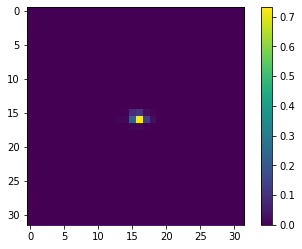

In [9]:
print(y_train[exmpl])
plt.imshow(x_train[exmpl, :, :])
plt.colorbar()

1.0


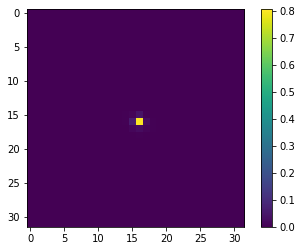

In [10]:
# Print example including label
print(y_test[exmpl])
plt.imshow(x_test[exmpl, :, :])
plt.colorbar()

3. change dimensions to numpy format

In [11]:
## Reorder shape to numpy format (row=axis0, column=axis1, channel=axis2 image resize for tf.image.resize with 3D-Tensor shape:
#Args for f.image.resize (https://www.tensorflow.org/api_docs/python/tf/image/resize?hl=ja)
#images 	4-D Tensor of shape [batch, height, width, channels] or 3-D Tensor of shape [height, width, channels].
#size 	A 1-D int32 Tensor of 2 elements: new_height, new_width. The new size for the images.


## performance meas of tensor reordering methods => np.einsum better (care about idx of np.einsum)
%timeit x_train_reorder = np.moveaxis( x_train, 0, -1)
%timeit x_train_reorder = np.einsum('ijk -> kij', x_train)

x_train_reorder = np.moveaxis( x_train, 0, -1)
#x_train_reorder = np.einsum('ijk -> jki', x_train)  #ToDO check if height still heigth /suared doesnt matter
x_test_reorder = np.einsum('xyz -> yzx', x_test)

print('x_train shape rearranged: {}'.format(x_train_reorder.shape))
print('x_test shape rearranged: {}'.format(x_test_reorder.shape))
print(x_train[0,:,:])

The slowest run took 10.69 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 5.58 µs per loop
The slowest run took 14.60 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.7 µs per loop
x_train shape rearranged: (32, 32, 100)
x_test shape rearranged: (32, 32, 100)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


check if data channels are the same

1.0


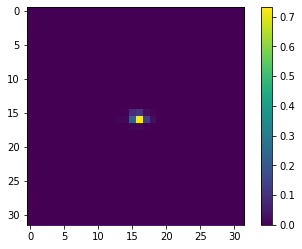

In [12]:
print(y_train[exmpl])
plt.imshow(x_train_reorder[:, :, exmpl])
plt.colorbar()

1.0


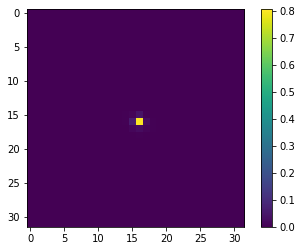

In [13]:
# Print example including label
print(y_test[exmpl])
plt.imshow(x_test_reorder[:, :, exmpl])
plt.colorbar()

4. Image resize for NISQ devices

(4, 4, 100)
random image 40 has label 1.0


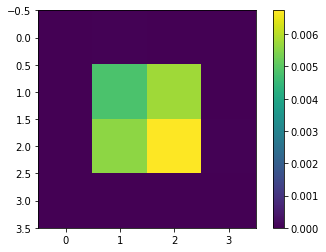

In [14]:
x_train_small = tf.image.resize(x_train_reorder,(img_pxl_dwngrd, img_pxl_dwngrd), antialias=True).numpy()
print(x_train_small.shape)
print('random image {} has label {}'.format(exmpl, y_train[exmpl]))
plt.imshow(x_train_small[:,:,exmpl])
plt.colorbar()

(4, 4, 100)
random image 40 has label 1.0


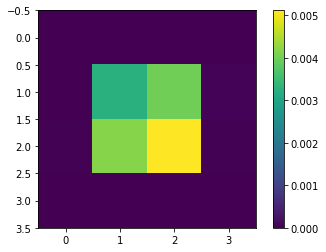

In [15]:
x_test_small = tf.image.resize(x_test_reorder,(img_pxl_dwngrd, img_pxl_dwngrd),preserve_aspect_ratio=True, antialias=True).numpy()

# Print 20th example including label
print(x_test_small.shape)
print('random image {} has label {}'.format(exmpl, y_test[exmpl]))
plt.imshow(x_test_small[:,:,exmpl])
plt.colorbar()

multiply all pixel values with * 10^2 for greater differences and still normalzed values

# Build Q - circuit from classical data

--> conversion to binary pixels

--> choose Threshold wisely (compare scales of plots of x_train_small/x_test_small

In [16]:
THRESH = 0.006 # get from scale in plot x_train_small/x_test_small
 
x_train_binary = np.array(x_train_small > THRESH, dtype=np.float32)
x_test_binary = np.array(x_test_small > THRESH, dtype=np.float32)
#x_test_small.shape

print(x_train_binary.view())
print(x_train_binary.shape)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 1. ... 0. 1. 1.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
(4, 4, 100)


random train image 40 has label 1.0


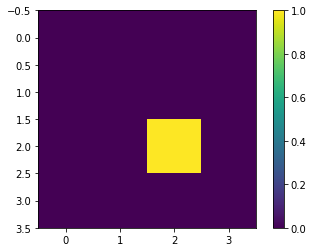

In [17]:
print('random train image {} has label {}'.format(exmpl, y_train[exmpl]))
plt.imshow(x_train_binary[:,:,exmpl])
plt.colorbar()

random test image 40 has label 1.0


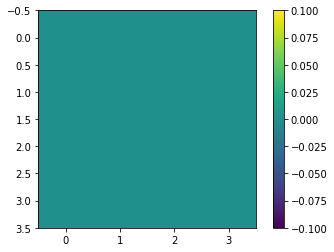

In [18]:
print('random test image {} has label {}'.format(exmpl, y_test[exmpl]))
plt.imshow(x_test_binary[:,:,exmpl])
plt.colorbar()

In [19]:
print(type(x_train_binary))

print(x_train_binary.shape[-1])

<class 'numpy.ndarray'>
100


In [20]:
print(x_train_binary.shape)
print(x_train_binary[:,:,0])

(4, 4, 100)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [21]:
for i in range(x_train_binary.shape[-1]):
  print(x_train_binary[...,i])
#for idx, x in np.ndenumerate(x_train_binary):
 # print(idx, x) 

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0

In [22]:
flat_img = np.ndarray.flatten(x_train_binary[:,:,0])   #flat image to have only one for loop
print(len(flat_img))
print(flat_img)

16
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [23]:
 for x in x_train_binary:
   print(x)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

# Create Q - Circuit

1. x-gate ( at each array element with  1)

In [24]:
def convert_to_circuit(image, pixel_number_height, pixel_number_width):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(pixel_number_height, pixel_number_width)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


#x_train_cirq  = [convert_to_circuit(x) for x in x_train_binary]
#x_test_cirq   = [conv_bnry_to_circuit(x) for x in x_test_binary]

In [25]:
x_train_cirq_lst  = []
x_test_cirq_lst   = []

for i in range(x_train_binary.shape[-1]):
  x_train_cirq = convert_to_circuit(x_train_binary[...,i], img_pxl_dwngrd, img_pxl_dwngrd )
  x_test_cirq = convert_to_circuit(x_test_binary[...,i],img_pxl_dwngrd,img_pxl_dwngrd)
  x_train_cirq_lst.append(x_train_cirq) 
  x_test_cirq_lst.append(x_test_cirq)

In [26]:
SVGCircuit(x_train_cirq_lst[exmpl])
print('Circuit elements for pixel / elements with 1 for example{}'.format(exmpl) )

Circuit elements for pixel / elements with 1 for example40


In [27]:
bin_img_train = x_train_binary[:,:,exmpl]
indices = np.array(np.where(bin_img_train)).T
indices

array([[2, 2]])

In [43]:
SVGCircuit(x_test_cirq_lst[exmpl])

ValueError: ignored

In [29]:
bin_img_test = x_test_binary[:,:,exmpl]
indices = np.array(np.where(bin_img_test)).T
indices

array([], shape=(0, 2), dtype=int64)

2. Convert Cirq Circuit to Tensors for TFQ

In [30]:
x_train_tfqcirc = tfq.convert_to_tensor(x_train_cirq_lst)
x_test_tfqcirc = tfq.convert_to_tensor(x_test_cirq_lst)

# QNN for Classification

  https://arxiv.org/pdf/1802.06002.pdf

1. Circuit for binary images

In [217]:
class CircuitLayerBuilder():
  def __init__(self, nmbr_data_qubits, readout):
    self.nmbr_data_qubits = nmbr_data_qubits
    self.readout = readout

  def add_layer(self, circuit, gate, prefix):
    for idx, qubit in enumerate(self.nmbr_data_qubits):
      symbol = sympy.Symbol(prefix + '-' + str(idx))
      circuit.append(gate(qubit, self.readout)**symbol)

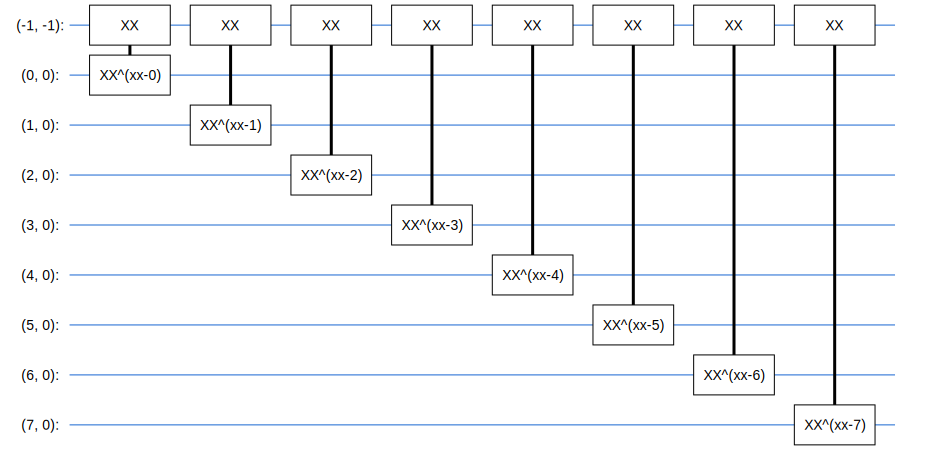

In [220]:
def circuit_binary_img_one_layer(img_pixel_nmbr_height, img_pxl_nmbr_width):
  circuit_binary_image = CircuitLayerBuilder(nmbr_data_qubits = cirq.GridQubit.rect(img_pixel_nmbr_height,1), readout=cirq.GridQubit(-1,-1))
  circuit = cirq.Circuit()
  circuit_binary_image.add_layer(circuit, gate = cirq.XX, prefix='xx')
  
  return circuit

SVGCircuit(circuit_binary_img_one_layer(img_pxl_dwngrd*2,img_pxl_dwngrd*2 ))

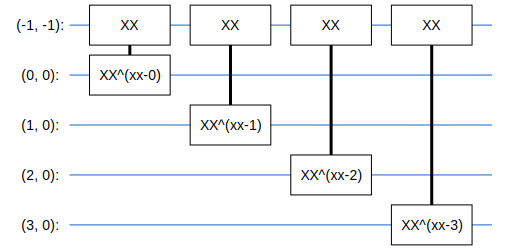

In [110]:
circuit_qnn = CircuitLayerBuilder(nmbr_data_qubits = cirq.GridQubit.rect(img_pxl_dwngrd,1), readout=cirq.GridQubit(-1,-1))
circuit = cirq.Circuit()
circuit_qnn.add_layer(circuit, gate = cirq.XX, prefix='xx')

SVGCircuit(circuit)

2. 2-layered Quantum  Neural Net matching circuit size and preoare for measurements*

In [33]:
def create_qnn_model(nmbr_layers, nmbr_circuit_gridqubits_0, nmbr_circuit_gridqubits_1):
  data_qubits =cirq.GridQubit.rect(nmbr_circuit_gridqubits_0, nmbr_circuit_gridqubits_1)
  readout = cirq.GridQubit(-1,-1)
  circuit = cirq.Circuit()

  # prep readout qubit
  circuit.append(cirq.X(readout))
  circuit.append(cirq.H(readout))
  
  # Build circuit
  builder = CircuitLayerBuilder(nmbr_data_qubits = data_qubits, readout=readout)

  # Add QNN layers
  for i in range(nmbr_layers):
    builder.add_layer(circuit, cirq.XX, 'xx{}'.format(i + 1))
    builder.add_layer(circuit, cirq.ZZ, 'zz{}'.format(i + 1))

  # prepare readout qubits for measurements of outcome
  circuit.append(cirq.H(readout))

  return circuit, cirq.Z(readout)
  

3. create QNN model

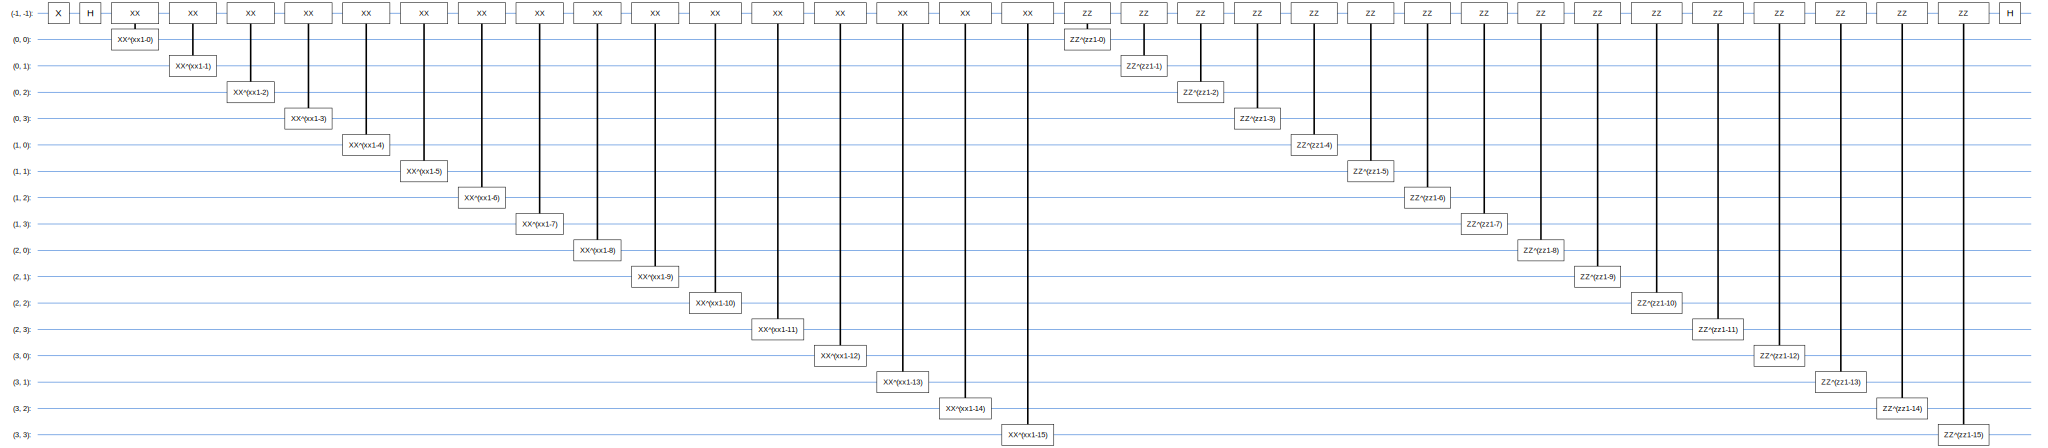

In [34]:
model_circuit, model_readout = create_qnn_model(1, img_pxl_dwngrd, img_pxl_dwngrd)
SVGCircuit(model_circuit)

6. QNN model to tfq-keras model using PQC(Parameterized Quantum Circuit) layer


(Build the Keras model with the quantum components. This model is fed the "quantum data", from x_train_circ, that encodes the classical data. It uses a Parametrized Quantum Circuit layer, tfq.layers.PQC, to train the model circuit, on the quantum data.

To classify these images, Farhi et al. proposed taking the expectation of a readout qubit in a parameterized circuit. The expectation returns a value between 1 and -1.)

In [35]:
model = tf.keras.Sequential([                
 # input is data-circuit, encoded as a tf.string
 tf.keras.layers.Input(shape=(), dtype=tf.string),
 #PQC layer returns expected value of the readout gate with range [-1,1]
 tfq.layers.PQC(model_circuit, model_readout)
])


Next, describe the training procedure to the model, using the compile method.

Since the the expected readout is in the range [-1,1], optimizing the hinge loss is a somewhat natural fit.
Note: Another valid approach would be to shift the output range to [0,1], and treat it as the probability the model assigns to class 3. This could be used with a standard a tf.losses.BinaryCrossentropy loss.

To use the hinge loss here you need to make two small adjustments. First convert the labels, y_train_nocon, from boolean to [-1,1], as expected by the hinge loss.

In [36]:
# For hinge loss vonvert labels from [0,1] to [-1, 1]

y_train_hinge_loss = 2.0 * y_train -1 
y_test_hinge_loss = 2.0 * y_test -1 

print('labels train [0,1]:\n {}'.format(y_train))
print('labels test [0,1]:\n {}'.format(y_test))
print('labels train [-1,1]:\n {}'.format(y_train_hinge_loss))
print('labels test [-1,1]:\n {}'.format(y_test_hinge_loss))

labels train [0,1]:
 [1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1.
 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0.
 1. 1. 0. 1.]
labels test [0,1]:
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0.
 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1.]
labels train [-1,1]:
 [ 1.  1.  1. -1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1. -1.  1.  1. -1.
 -1.  1. -1. -1.  1. -1.  1. -1.  1.  1. -1. -1.  1. -1.  1.  1. -1. -1.
  1.  1. -1.  1.  1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1.
 -1. -1. -1.  1.  1.  1. -1.  1. 

Second, use a custiom hinge_accuracy metric that correctly handles [-1, 1] as the y_true labels argument. tf.losses.BinaryAccuracy(threshold=0.0) expects y_true to be a boolean, and so can't be used with hinge loss).

In [37]:
def hinge_accuracy(y_true, y_pred):
  y_true = tf.squeeze(y_true) > 0.0
  y_pred = tf.squeeze(y_pred) > 0.0
  result = tf.cast(y_true == y_pred, tf.float32)

  return tf.reduce_mean(result)

compile model 
- hinge loss
- ADAM (of grad desc)
- hinge accuracy

In [38]:
model.compile(loss=tf.keras.losses.Hinge(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics=[hinge_accuracy])

In [39]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


7. Train Model

In [40]:
EPOCHS = 5
BATCH_SIZE = 2
NUM_EXAMPLES = len(x_train_tfqcirc)

In [41]:
x_train_tfcirq_sub = x_train_tfqcirc[: NUM_EXAMPLES]
y_train_hinge_loss_sub = y_train_hinge_loss[: NUM_EXAMPLES]

In [45]:
qnn_history = model.fit(
      x_train_tfcirq_sub, y_train_hinge_loss_sub,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfqcirc, y_test_hinge_loss))

qnn_results = model.evaluate(x_test_tfqcirc, y_test_hinge_loss)

Epoch 1/5
50/50 [==============================] - 7s 145ms/step - loss: 1.0020 - hinge_accuracy: 0.4400 - val_loss: 0.9994 - val_hinge_accuracy: 0.5400
Epoch 2/5
50/50 [==============================] - 7s 144ms/step - loss: 1.0002 - hinge_accuracy: 0.5200 - val_loss: 1.0007 - val_hinge_accuracy: 0.4800
Epoch 3/5
50/50 [==============================] - 7s 143ms/step - loss: 0.9982 - hinge_accuracy: 0.5400 - val_loss: 1.0014 - val_hinge_accuracy: 0.4800
Epoch 4/5
50/50 [==============================] - 7s 143ms/step - loss: 0.9965 - hinge_accuracy: 0.5400 - val_loss: 1.0025 - val_hinge_accuracy: 0.4800
Epoch 5/5
50/50 [==============================] - 7s 146ms/step - loss: 0.9946 - hinge_accuracy: 0.5500 - val_loss: 1.0039 - val_hinge_accuracy: 0.4800


NameError: ignored

In [46]:
qnn_results = model.evaluate(x_test_tfqcirc, y_test_hinge_loss)

4/4 [==============================] - 1s 161ms/step - loss: 1.0039 - hinge_accuracy: 0.5938


# Test:

1. Model:
- pixel with 6,6 
- 2 layers 

2. Model Hyperparams:
- batch size 1
- epochs 5

--> not trainable (RAM Colab crashes)



# Results:
A) hinge accuracy with 4x4 pixel, 1 qnn layer, 10 epochs, batch size 16 :
- 0.5625

#QCNN:

- Full QUANTUM
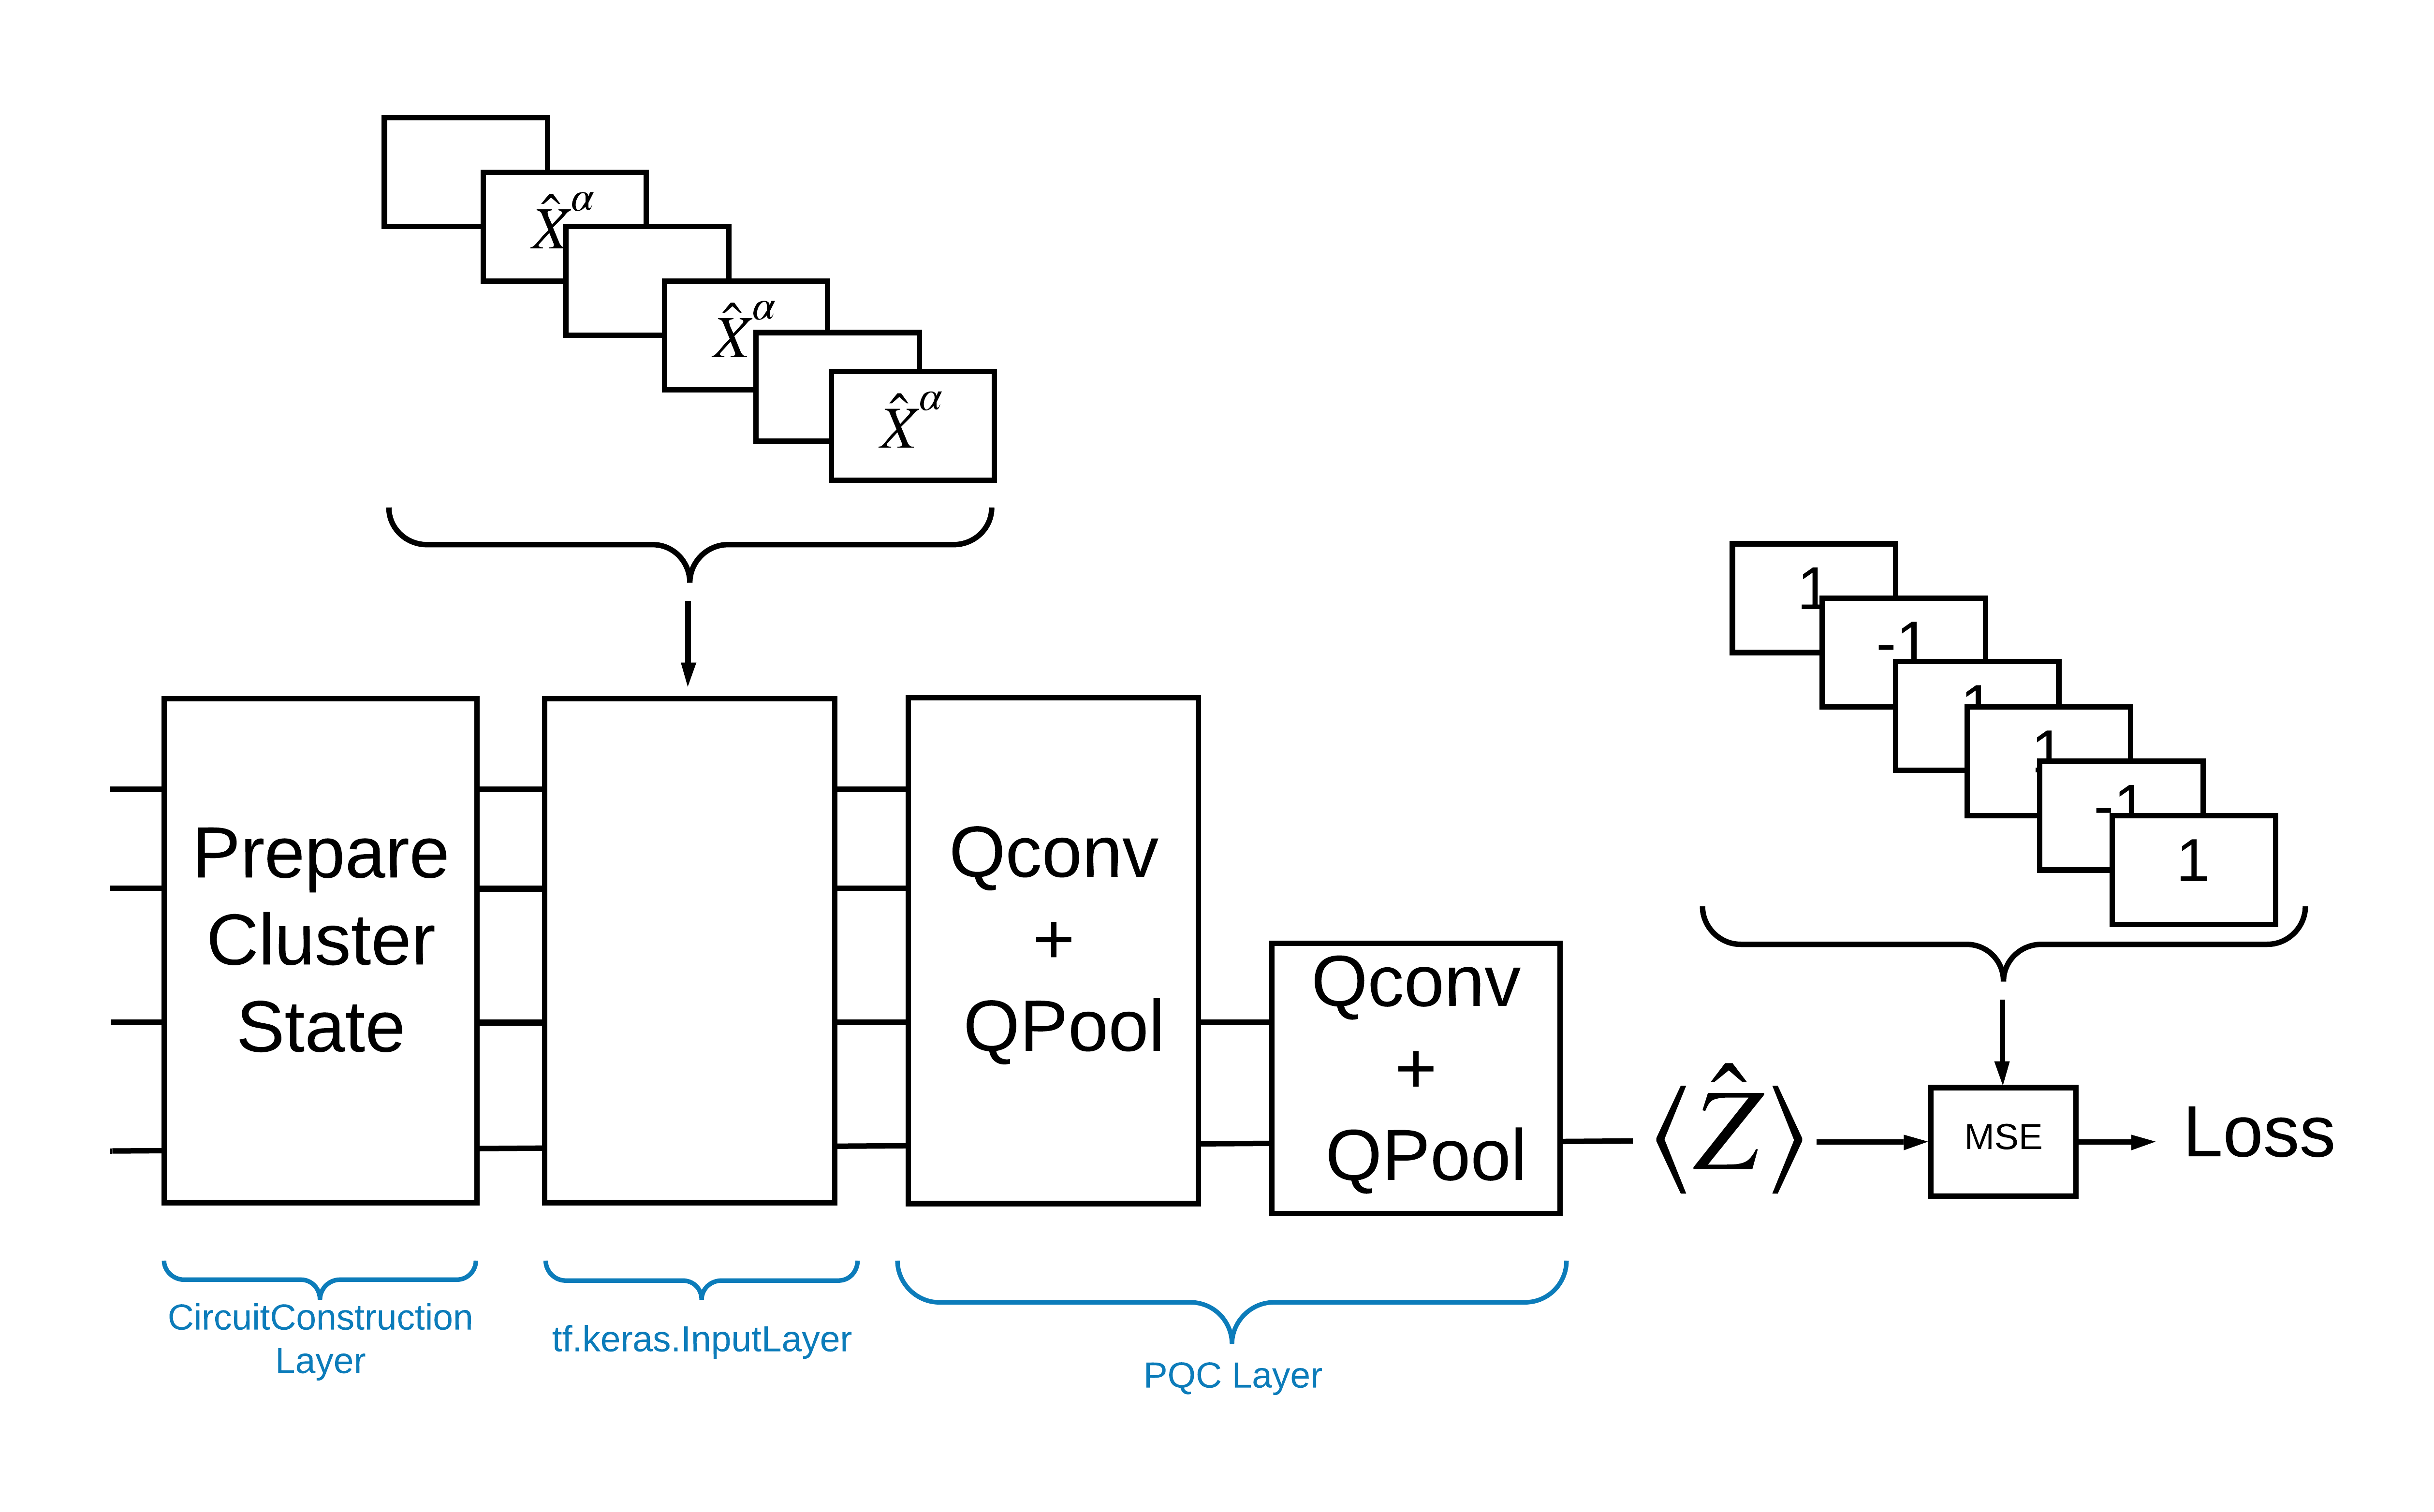

Tutorial with cluster states (excitet = 1 or not = 0)

1. Data

In [47]:
def generate_data(qubits):
  """Gen train/ test data """
  n_rounds = 20 # produces n_rounds * n_qubits datapoints
  excitations = []
  labels = []

  for n in range(n_rounds):
    for bit in qubits:

      rng = np.random.uniform(-np.pi, np.pi)
      excitations.append(cirq.Circuit(cirq.rx(rng)(bit)))
      labels.append(1 if (-np.pi / 2) <= rng <= (np.pi /2) else -1)

  split_ind = int(len(excitations) * 0.7) # dataset split
  train_excitations = excitations[: split_ind]
  test_excitations  = excitations[split_ind :]

  train_labels = labels[: split_ind]
  test_labels  = labels[split_ind :]

  return tfq.convert_to_tensor(train_excitations), np.array(train_labels),\
  tfq.convert_to_tensor(test_excitations), np.array(test_labels)


In [48]:
sample_points, sample_labels, _, __ = generate_data(cirq.GridQubit.rect(1, 4))
print('Input:', tfq.from_tensor(sample_points)[0], 'Output:', sample_labels[0])
print('Input:', tfq.from_tensor(sample_points)[1], 'Output:', sample_labels[1])


Input: (0, 0): ───Rx(0.446π)─── Output: 1
Input: (0, 1): ───Rx(-0.538π)─── Output: -1


2. Cluster state

In [49]:
def cluster_state_circuit(bits):
    """Return a cluster state on the qubits in `bits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

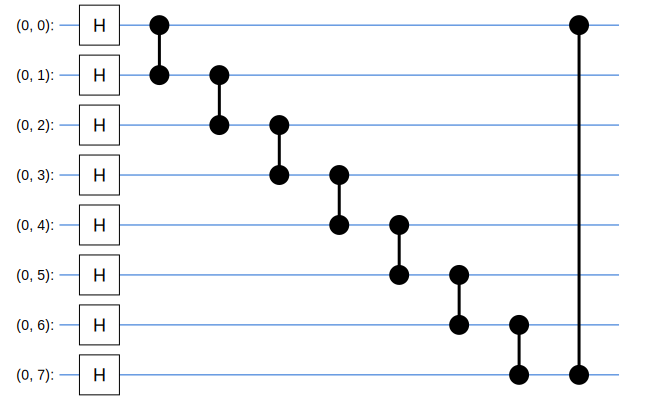

In [213]:
SVGCircuit(cluster_state_circuit(cirq.GridQubit.rect(1, 8)))

##QCNN Layer

1. Basic Elements for QCNN 
 - variational gates (defined by exponents of gates (created with sympy) define learnable parameters



1.1 Unitary matrices = layers for one and two qubits

In [75]:
def one_qubit_unitary(bit, symbols):
  """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
  Y and Z axis, that depends on the values in `symbols`."""
  return cirq.Circuit(
      cirq.X(bit)**symbols[0],
      cirq.Y(bit)**symbols[1],
      cirq.Z(bit)**symbols[2]
  )

def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit

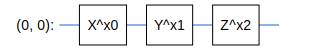

In [52]:
SVGCircuit(one_qubit_unitary(cirq.GridQubit(0, 0) , sympy.symbols('x0:3')) ) 

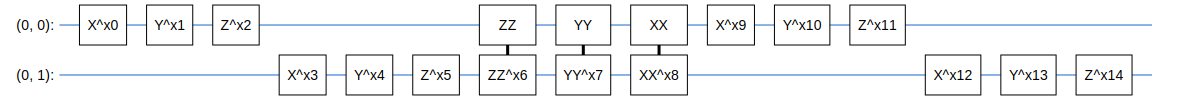

In [53]:
SVGCircuit(two_qubit_unitary(cirq.GridQubit.rect(1,2), sympy.symbols('x0:15')))

2. Quantum Convolution

In [246]:
import itertools
def quantum_conv_circuit(bits, symbols):
  """  Quantum Conv layer like from QCNN paper:
  Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above. """

  circuit = cirq.Circuit()
  # cascade from first qubit (0,0) to the last qubit with two qubit unitaries
  #for first, second in zip(itertools.repeat(bits[0::2],len(bits)), bits[1::2]):
  #    circuit += two_qubit_unitary([first, second], symbols)
      
  #cascade from first qubit (0,0) to the last qubit with two qubit unitaries
  for first, second in zip(bits[0::2], bits[1::2]):
      circuit += two_qubit_unitary([first, second], symbols)
  
  #zip(itertools.repeat(float(price),len(bids)), bids)
  #  cascade from second qubit (0,1) to the last qubit with two qubit unitaries
  for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
      circuit += two_qubit_unitary([first, second], symbols)

  return circuit


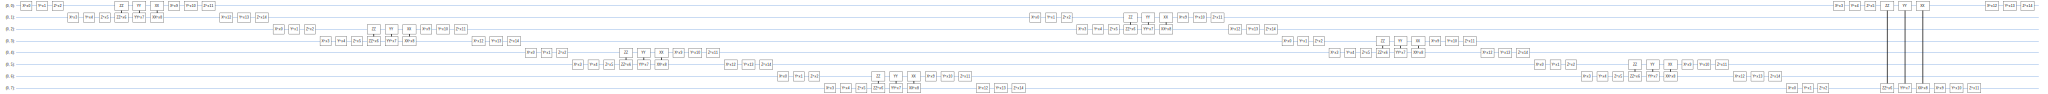

In [247]:
## Test for 8 qubits
SVGCircuit(quantum_conv_circuit(cirq.GridQubit.rect(1, 8), sympy.symbols('x0:15')))

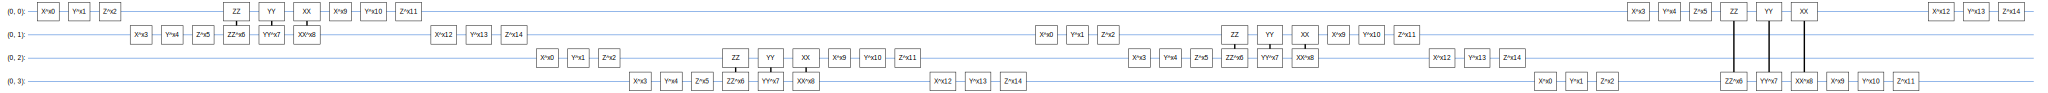

In [248]:
## Test for variable qubits (for image)
SVGCircuit(quantum_conv_circuit(cirq.GridQubit.rect(1, img_pxl_dwngrd), sympy.symbols('x0:15')))

3. Quantum Pooling

A quantum pooling layer pools from N qubits to N/2 qubits using the two-qubit pool defined above.

- Pooling layer with two qubits



In [221]:
def two_qubit_pool(source_qubit, sink_qubit, symbols):
  """ Make a Cirq circuit to do a paramterized 'pooling', which attempts to reduce entaglement
  down from to qubits to just one """

  pool_circuit = cirq.Circuit()
  sink_basis_selector = one_qubit_unitary(sink_qubit,symbols[0:3])
  source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])

  pool_circuit.append(sink_basis_selector)
  pool_circuit.append(source_basis_selector)
  pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
  pool_circuit.append(sink_basis_selector**-1)

  return pool_circuit

In [222]:
def quantum_pool_circuit(source_bits, sink_bits, symbols):
  """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """
  circuit = cirq.Circuit()
  for source, sink in zip(source_bits, sink_bits):
    circuit += two_qubit_pool(source, sink, symbols)

  return circuit

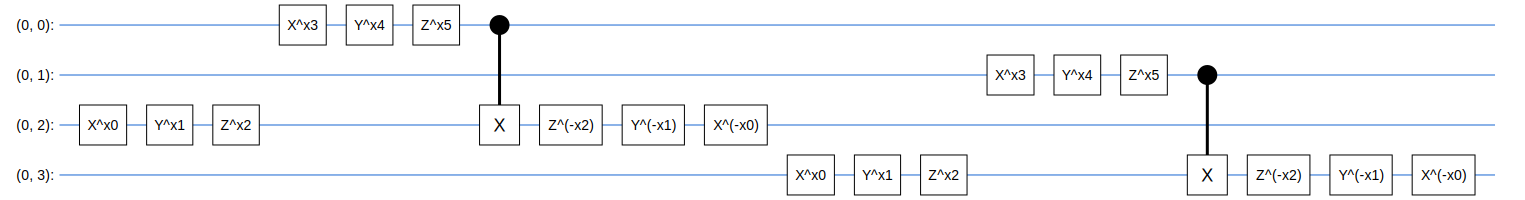

In [223]:
## TEST Pooling circuit
test_bits = cirq.GridQubit.rect(1, img_pxl_dwngrd)
test_source_bit = round(img_pxl_dwngrd/2)
SVGCircuit(quantum_pool_circuit(test_bits[:test_source_bit], test_bits[test_source_bit:], sympy.symbols('x0:6')))

## Model Definition using conv and pool layers



Now use the defined layers to construct a purely quantum CNN. Start with eight qubits, pool down to one, then measure < Z >.





## TODO: write circuit function depending on input data 

POOL from full image down until only two outputs automatically (Pool layer always halfs width/height pixel number)

In [224]:
from PIL import Image
def make_square(img, image_pixel_height , image_pixel_width, min_size=256, fill_color=(0, 0, 0, 0)):
    x, y = image_pixel_width, image_pixel_height
    size = max(min_size, x, y)
    new_im = Image.new('RGBA', (size, size), fill_color)
    new_im.paste(img, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

In [225]:
# number of qubits 2^x for image

def create_model_circuit_var_img(qubits, image_pixel_height, image_pixel_width):
  """Create sequence of alternating convolution and pooling operators 
  which gradually shrink over time."""

  ## check image 
  # check image also if multiple of 2: 
  # (n & (n-1) == 0) and n != 0
  # lambda x: 2^x  

  if image_pixel_height != image_pixel_width and image_pixel_height % 2 != 0 :
    raise Exception("Sorry, image is not square, use make_square function on image first") 

  model_circuit = cirq.Circuit()
  symbol_nmbr_conv = 16
  symbol_nmbr_pool = 6

  diff_symbol_conv = 16 - 1
  int_symbol_nmbr_conv_1 = 0
  int_symbol_nmbr_conv_2 = symbol_nmbr_conv - 1

  pool_bit_init = image_pixel_height/2

  full_amount_symbols = symbol_nmbr_conv + symbol_nmbr_pool
  int_nmbr_symbols = full_amount_symbols-1
  symbols = sympy.symbols('qconv0:{}'.format(int_nmbr_symbols))

  # cirq uses sympy.Symbols to map leanable variables. TFQ scans incoming circuits
  # and replaces these with TF variables

  counter = 0
  while (image_pixel_height/2) > 1:
    ## pool down image always at half image size and add 16 symbols each conv layer
    ## and 6 symbols each pool layer

    if counter == 0:
      # model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
      # model_circuit += quantum_pool_circuit(qubits[:4], qubits[4:], symbols[15:21])

      model_circuit += quantum_conv_circuit(qubits, symbols[int_symbol_nmbr_conv_1:int_symbol_nmbr_conv_2])

      int_symbol_nmbr_conv_1 = int_symbol_nmbr_conv_2
      int_symbol_nmbr_conv_2 = int_symbol_nmbr_conv_1 + symbol_nmbr_pool

      model_circuit += quantum_pool_circuit(qubits[: pool_bit_init], qubits[pool_bit_init :], symbols[int_symbol_nmbr_conv_1 : int_symbol_nmbr_conv_2])

      #########
      full_amount_symbols = full_amount_symbols + symbol_nmbr_conv + symbol_nmbr_pool
      int_nmbr_symbols = full_amount_symbols-1
      symbols = sympy.symbols('qconv0:{}'.format(int_nmbr_symbols))
      

      img_pixel_amount =  image_pixel_height/2
      pool_bit_2 = img_pixel_amount/2
      pool_bit_updt_1 = pool_bit_init
      pool_bit_updt_2 = img_pixel_amount + pool_bit_2
      img_pixel_amount /= 2


    else:
      # model_circuit += quantum_conv_circuit(qubits[4:], symbols[21:36])
      # model_circuit += quantum_pool_circuit(qubits[4:6], qubits[6:], symbols[36:42])

      int_symbol_nmbr_conv_1 = int_symbol_nmbr_conv_2
      int_symbol_nmbr_conv_2 = int_symbol_nmbr_conv_1 + diff_symbol_conv

      model_circuit += quantum_conv_circuit(qubits[pool_bit_updt_1 :], symbols[int_symbol_nmbr_conv_1 : int_symbol_nmbr_conv_2])


      int_symbol_nmbr_conv_1 = int_symbol_nmbr_conv_2
      int_symbol_nmbr_conv_2 = int_symbol_nmbr_conv_1 + symbol_nmbr_pool

      model_circuit += quantum_pool_circuit(qubits[pool_bit_updt_1 : pool_bit_updt_2], qubits[pool_bit_updt_2 :], symbols[int_symbol_nmbr_conv_1 : int_symbol_nmbr_conv_2])


      img_pixel_amount /= 2
      pool_bit_adding = pool_bit_updt_1
      pool_bit_updt_1 = pool_bit_updt_2
      pool_bit_updt_2 = pool_bit_adding + img_pixel_amount
    

      ###############
      full_amount_symbols = full_amount_symbols + symbol_nmbr_conv + symbol_nmbr_pool
      int_nmbr_symbols = full_amount_symbols-1
      symbols = sympy.symbols('qconv0:{}'.format(int_nmbr_symbols))
  
    counter += 1
    image_pixel_height /= 2


  ##model_circuit += quantum_conv_circuit(qubits[6:], symbols[42:57])
  ##model_circuit += quantum_pool_circuit([qubits[6]], [qubits[7]], symbols[57:63])
  int_symbol_nmbr_conv_1 = int_symbol_nmbr_conv_2
  int_symbol_nmbr_conv_2 = int_symbol_nmbr_conv_1 + diff_symbol_conv

  model_circuit += quantum_conv_circuit(qubits[pool_bit_updt_1:], symbols[int_symbol_nmbr_conv_1:int_symbol_nmbr_conv_2])

  int_symbol_nmbr_conv_1 = int_symbol_nmbr_conv_2
  int_symbol_nmbr_conv_2 = int_symbol_nmbr_conv_1 + symbol_nmbr_pool

  model_circuit += quantum_pool_circuit(qubits[pool_bit_updt_1], qubits[pool_bit_updt_2], symbols[int_symbol_nmbr_conv_1:int_symbol_nmbr_conv_2])

  

  return model_circuit

In [226]:
def create_model_circuit(qubits):
  """Create sequence of alternating convolution and pooling operators 
  which gradually shrink over time."""

  model_circuit = cirq.Circuit()
  symbols = sympy.symbols('qconv0:63')

  # cirq uses sympy.Symbols to map leanable variables. TFQ scans incoming circuits
  # and replaces these with TF variables

  model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
  model_circuit += quantum_pool_circuit(qubits[:4], qubits[4:], symbols[15:21])

  model_circuit += quantum_conv_circuit(qubits[4:], symbols[21:36])
  model_circuit += quantum_pool_circuit(qubits[4:6], qubits[6:], symbols[36:42])

  model_circuit += quantum_conv_circuit(qubits[6:], symbols[42:57])
  model_circuit += quantum_pool_circuit([qubits[6]], [qubits[7]], symbols[57:63])

  return model_circuit

In [227]:
# PREPARE model for image data

# Create our qubits and readout operators in Cirq
image_bits = cirq.GridQubit.rect(1,8)
readout_operators = cirq.Z(image_bits[-1])

# Build a sequential model enacting the logic in 1.3 of this notebook.
# Here you are making the static cluster state prep as a part of the AddCircuit and the
# "quantum datapoints" are coming in the form of excitation

excitation_input  = tf.keras.Input( shape=(), dtype=tf.dtypes.string )

image_state = tfq.layers.AddCircuit()(
    excitation_input, prepend=(circuit_binary_img_one_layer(img_pxl_dwngrd, img_pxl_dwngrd)))


quantum_model_img = tfq.layers.PQC(create_model_circuit_img(image_bits),
                               readout_operators)(image_state)


qcnn_model_img = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model_img])


tf.keras.utils.plot_model(qcnn_model_clust,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=100)


TypeError: ignored

In [228]:
def create_model_circuit(qubits):
  """Create sequence of alternating convolution and pooling operators 
  which gradually shrink over time."""

  model_circuit = cirq.Circuit()
  symbols = sympy.symbols('qconv0:63')

  # cirq uses sympy.Symbols to map leanable variables. TFQ scans incoming circuits
  # and replaces these with TF variables

  model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
  model_circuit += quantum_pool_circuit(qubits[:4], qubits[4:], symbols[15:21])

  model_circuit += quantum_conv_circuit(qubits[4:], symbols[21:36])
  model_circuit += quantum_pool_circuit(qubits[4:6], qubits[6:], symbols[36:42])

  model_circuit += quantum_conv_circuit(qubits[6:], symbols[42:57])
  model_circuit += quantum_pool_circuit([qubits[6]], [qubits[7]], symbols[57:63])

  return model_circuit


## Model **Training**

###Cluster  states

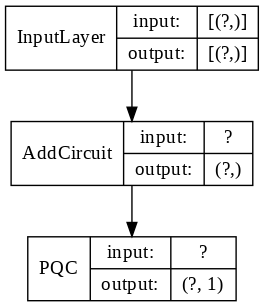

In [229]:
# Create our qubits and readout operators in Cirq
cluster_state_bits = cirq.GridQubit.rect(1,8)
readout_operators = cirq.Z(cluster_state_bits[-1])

# Build a sequential model enacting the logic in 1.3 of this notebook.
# Here you are making the static cluster state prep as a part of the AddCircuit and the
# "quantum datapoints" are coming in the form of excitation

excitation_input  = tf.keras.Input( shape=(), dtype=tf.dtypes.string )
cluster_state = tfq.layers.AddCircuit()(
    excitation_input, prepend=cluster_state_circuit(cluster_state_bits))


quantum_model = tfq.layers.PQC(create_model_circuit(cluster_state_bits),
                               readout_operators)(cluster_state)


qcnn_model_clust = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])


tf.keras.utils.plot_model(qcnn_model_clust,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=100)


In [ ]:
# 1. Generate some training data
train_excitations, train_labels, test_excitatios, test_labels = generate_data(cluster_state_bits)

# 2. try to use image data:

# custom accuracy metric:
@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))

In [151]:
# Generate some training data.
train_excitations, train_labels, test_excitations, test_labels = generate_data(
    cluster_state_bits)


# Custom accuracy metric.
@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))


qcnn_model_clust.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.losses.mse,
                   metrics=[custom_accuracy])


qcnn_history_clust = qcnn_model_clust.fit(x=train_excitations,
                         y=train_labels,
                         batch_size=16,
                         epochs=25,
                         verbose=1,
                         validation_data=(test_excitations, test_labels))

Epoch 1/25
7/7 [==============================] - 1s 166ms/step - loss: 0.8652 - custom_accuracy: 0.7946 - val_loss: 0.7855 - val_custom_accuracy: 0.8958
Epoch 2/25
7/7 [==============================] - 1s 147ms/step - loss: 0.7674 - custom_accuracy: 0.7857 - val_loss: 0.7364 - val_custom_accuracy: 0.7917
Epoch 3/25
7/7 [==============================] - 1s 149ms/step - loss: 0.7154 - custom_accuracy: 0.7857 - val_loss: 0.7212 - val_custom_accuracy: 0.7917
Epoch 4/25
7/7 [==============================] - 1s 165ms/step - loss: 0.6961 - custom_accuracy: 0.8214 - val_loss: 0.6928 - val_custom_accuracy: 0.8125
Epoch 5/25
7/7 [==============================] - 1s 162ms/step - loss: 0.6887 - custom_accuracy: 0.8214 - val_loss: 0.6945 - val_custom_accuracy: 0.8125
Epoch 6/25
7/7 [==============================] - 1s 154ms/step - loss: 0.6891 - custom_accuracy: 0.7946 - val_loss: 0.7050 - val_custom_accuracy: 0.8333
Epoch 7/25
7/7 [==============================] - 1s 150ms/step - loss: 0.68

In [117]:
qcnn_results_clust = model.evaluate(test_excitations, test_labels)

2/2 [==============================] - 0s 98ms/step - loss: 0.9317 - hinge_accuracy: 0.6562


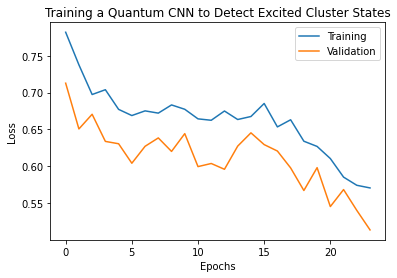

In [118]:
plt.plot(qcnn_history_clust.history['loss'][1:], label='Training')
plt.plot(qcnn_history_clust.history['val_loss'][1:], label='Validation')
plt.title('Training a Quantum CNN to Detect Excited Cluster States')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Image data (photon <-> electron data)

In [119]:
qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.losses.mse,
                   metrics=[hinge_accuracy])


history = qcnn_model.fit(x=x_train_tfcirq_sub,
                         y=y_train_hinge_loss_sub,
                         batch_size=16,
                         epochs=25,
                         verbose=1,
                         validation_data=(x_test_tfqcirc, y_test_hinge_loss))

Epoch 1/25
7/7 [==============================] - 2s 251ms/step - loss: 0.9924 - hinge_accuracy: 0.6071 - val_loss: 1.0705 - val_hinge_accuracy: 0.5179
Epoch 2/25
7/7 [==============================] - 2s 218ms/step - loss: 0.9872 - hinge_accuracy: 0.4643 - val_loss: 1.0003 - val_hinge_accuracy: 0.5179
Epoch 3/25
7/7 [==============================] - 1s 211ms/step - loss: 0.9805 - hinge_accuracy: 0.5804 - val_loss: 1.0487 - val_hinge_accuracy: 0.5179
Epoch 4/25
7/7 [==============================] - 1s 211ms/step - loss: 0.9916 - hinge_accuracy: 0.5536 - val_loss: 1.0339 - val_hinge_accuracy: 0.5179
Epoch 5/25
7/7 [==============================] - 1s 214ms/step - loss: 0.9885 - hinge_accuracy: 0.5536 - val_loss: 1.0238 - val_hinge_accuracy: 0.5179
Epoch 6/25
7/7 [==============================] - 2s 216ms/step - loss: 0.9996 - hinge_accuracy: 0.5804 - val_loss: 1.0346 - val_hinge_accuracy: 0.5179
Epoch 7/25
7/7 [==============================] - 2s 245ms/step - loss: 0.9902 - hinge_a

In [98]:
qcnn_results = model.evaluate(x_test_tfqcirc, y_test_hinge_loss)

4/4 [==============================] - 1s 164ms/step - loss: 1.0184 - hinge_accuracy: 0.5781


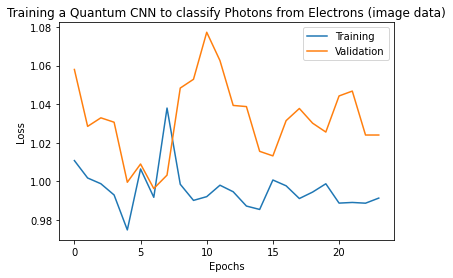

In [99]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')
plt.title('Training a Quantum CNN to classify Photons from Electrons (image data)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [71]:
qnn_history = model.fit(
      x_train_tfcirq_sub, y_train_hinge_loss_sub,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfqcirc, y_test_hinge_loss))

qnn_results = model.evaluate(x_test_tfqcirc, y_test_hinge_loss)

Epoch 1/5
50/50 [==============================] - 7s 145ms/step - loss: 0.9919 - hinge_accuracy: 0.5500 - val_loss: 1.0056 - val_hinge_accuracy: 0.4600
Epoch 2/5
50/50 [==============================] - 7s 138ms/step - loss: 0.9890 - hinge_accuracy: 0.5600 - val_loss: 1.0085 - val_hinge_accuracy: 0.4600
Epoch 3/5
50/50 [==============================] - 7s 138ms/step - loss: 0.9857 - hinge_accuracy: 0.5600 - val_loss: 1.0115 - val_hinge_accuracy: 0.4600
Epoch 4/5
50/50 [==============================] - 7s 135ms/step - loss: 0.9787 - hinge_accuracy: 0.5600 - val_loss: 1.0149 - val_hinge_accuracy: 0.4600
Epoch 5/5
4/4 [==============================] - 1s 157ms/step - loss: 1.0184 - hinge_accuracy: 0.5781


In [ ]:
assert False

In [ ]:
bin_img = x_train_binary[:,:,0]
indices = np.array(np.where(bin_img)).T
indices

In [ ]:
x_train_cirq  = [convert_to_circuit(x) for x in x_train_binary]
x_test_cirq   = [conv_bnry_to_circuit(x) for x in x_test_binary]

SVGCircuit(x_train_cirq[0])

In [ ]:
def convert_to_circuit(image, number_of_qubits):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(number_of_qubits, number_of_qubits)
    circuit = cirq.Circuit()

    for idx, value in enumerate(values):
      print(idx, value)
      if value:
        circuit.append(cirq.X(qubits[idx]))
        
    return circuit


x_train_cirq  = [convert_to_circuit(x, qubit_nmbrs) for x in x_train_binary]
x_test_cirq   = [conv_bnry_to_circuit(x, qubit_nmbrs) for x in x_test_binary]

In [ ]:
print(x_train_small[:,:,0])
print(x_train_small[-1,-1,0])
value = x_train_small[-1,-1,0]
value = value*10**5
print(value)

In [ ]:
factor_normalization = 10

x_test_refact = x_test_small
print(x_test_refact.shape)

np.multiply(x_test_refact[:,0], factor_normalization)
np.multiply(x_test_refact[:,1], factor_normalization)


print(x_test_refact[1])

print(x_test_refact.shape)
print(y_test[0])
plt.imshow(x_test_refact[:,:,prnt_exmpl])
plt.colorbar()